# Init

In [1]:
using Pkg
Pkg.activate("../one_flav_env")

using DataFrames
using CSV
using StaticArrays
using LinearAlgebra
using LaTeXStrings
using DelimitedFiles: readdlm
using Optim
using PythonPlot

rc("font", family="serif", serif="Computer Modern", size=14)
rc("figure", autolayout=true)
rc("axes", labelsize=16, unicode_minus=false)
rc("text", usetex=true)
rc("text.latex", preamble=raw"\usepackage{slashed}")

golden_rat = (1+sqrt(5))/2

MG_RESULTS_DIR = "../madgraph/"
FIGDIR = "./"

# make sure these match what the script has output
DIR_llνν = MG_RESULTS_DIR * "mumu_to_llvv/"
DIR_mumu = MG_RESULTS_DIR * "mumu_to_llchichi/"
DIR_vbf = MG_RESULTS_DIR * "VV_to_llchichi/"

DIR_mumu_phiscan = MG_RESULTS_DIR * "phiscan/" * "mumu_to_llchichi/"
DIR_vbf_phiscan = MG_RESULTS_DIR * "phiscan/" * "VV_to_llchichi/"

SUMMARY_FILENAME = "dilepton_summary.csv"
RUN_RESULTS_FILENAME = "run_info.csv"

SR_table_3 = CSV.read("table_rts=3.csv", DataFrame)
SR_table_10 = CSV.read("table_rts=10.csv", DataFrame)

function dir_runx(x)
    if x < 10
        return "Events/run_0$x/"
    else
        return "Events/run_$x/"
    end
end
;

  Activating project at `~/Dropbox (University of Oregon)/MuC/Aria/one_flav/code/one_flav_env`


In [2]:
function load_summary(rundir)
    Matrix(CSV.read(rundir*SUMMARY_FILENAME, DataFrame))'
end

function load_run_info(mgdir)
    CSV.read(mgdir*RUN_RESULTS_FILENAME, DataFrame)
end

function get_bkg_at_rts(rts_tev; bkg_dir=DIR_llνν)
    rts_gev = Float64(rts_tev)*1e3

    run_info = load_run_info(bkg_dir)
    idxs = findall(x -> x == rts_gev, run_info[:,1])
    run_info = run_info[idxs,:]

    if length(idxs) > 1
        throw(ArgumentError("too many bkgs"))
    else
        bkg_summary = load_summary(bkg_dir*dir_runx(idxs[1]))
    end

    return run_info, bkg_summary
end

function get_runs_at_rts(rts_tev; bkg_dir=DIR_llνν, mumu_dir=DIR_mumu_phiscan,
        vbf_dir=DIR_vbf_phiscan)
    
    rts_gev = Float64(rts_tev)*1e3

    mumu_info = load_run_info(mumu_dir)
    vbf_info = load_run_info(vbf_dir)

    mumu_idxs = findall(x -> x == rts_gev, mumu_info[:,1])
    vbf_idxs = findall(x -> x == rts_gev, vbf_info[:,1])

    if !(mumu_idxs == vbf_idxs)
        throw(ArgumentError("mumu and vbf runs don't match up..."))
    end

    mumu_info = mumu_info[mumu_idxs,:]
    vbf_info = vbf_info[vbf_idxs,:]

    bkg_info, bkg_summary = get_bkg_at_rts(rts_tev)

    return (rts=rts_gev, run_ids=mumu_idxs, mphis=mumu_info.mphi,
            mumu_xsecs=mumu_info.xsec, vv_xsecs=vbf_info.xsec,
            bkg_summary=bkg_summary, bkg_xsec=bkg_info.xsec[1],
            bkg_dir=bkg_dir, mumu_dir=mumu_dir, vbf_dir=vbf_dir)
end

function get_run_with_summary(rts_runs, i)
    mumu_summary = load_summary(rts_runs.mumu_dir *
                    dir_runx(rts_runs.run_ids[i]))
    vv_summary = load_summary(rts_runs.vbf_dir *
                    dir_runx(rts_runs.run_ids[i]))

    return (rts=rts_runs.rts, mphi=rts_runs.mphis[i], bkg_summary=rts_runs.bkg_summary,
        bkg_xsec=rts_runs.bkg_xsec, mumu_summary=mumu_summary, vv_summary=vv_summary,
        mumu_xsec=rts_runs.mumu_xsecs[i], vv_xsec=rts_runs.vv_xsecs[i])
end
;

In [7]:
function gtr_min(summ_vec, min)
    summ_vec .> min
end

function fcut(summary, mll_min, ptll_min, mt2_min)
    N_mll = length(mll_min)
    N_ptll = length(ptll_min)
    N_mt2 = length(mt2_min)
    Nevent = length(summary[1,:])

    res = zeros(Float64, (N_mll, N_ptll, N_mt2))

    mll_test = gtr_min.((summary[1,:],), mll_min)
    ptll_test = gtr_min.((summary[2,:],), ptll_min)
    mt2_test = gtr_min.((summary[5,:],), mt2_min)

    @Threads.threads for i in 1:N_mll
        @Threads.threads for j in 1:N_ptll
            @Threads.threads for k in 1:N_mt2
                res[i,j,k] = sum(mll_test[i] .&& ptll_test[j] .&& mt2_test[k])
            end
        end
    end

    return res ./ Nevent
end

function significances(run, lumi, mll_min, ptll_min, mt2_min)
    mumu_frac = fcut(run.mumu_summary, mll_min, ptll_min, mt2_min)
    vv_frac = fcut(run.vv_summary, mll_min, ptll_min, mt2_min)
    bkg_frac = fcut(run.bkg_summary, mll_min, ptll_min, mt2_min)

    N_mumu = run.mumu_xsec .* lumi .* mumu_frac
    N_vv = run.vv_xsec .* lumi .* vv_frac
    N_bkg_true = run.bkg_xsec .* lumi .* bkg_frac
    # N_bkg = @. (2+N_bkg_true) + sqrt((2+N_bkg_true)^2 - N_bkg_true^2)
    N_bkg = N_bkg_true .+ ((N_bkg_true .<= 2.0)*2.0)

    N_S = @. (N_mumu + N_vv)

    @. N_S *= (N_S >= 20)

    return N_S ./ sqrt.(N_bkg)
end

function max_sys(signif)
    (signif/5)^2-1    
end

function find_best_cuts_disc(run, lumi; ncuts=50, mincut=200.0, 
    integer_cuts=true)

    if integer_cuts
        cuts = (Vector{Int}(round.(range(mincut, run.rts, ncuts); sigdigits=2)), 
        Vector{Int}(round.(range(mincut, run.rts/2, ncuts); sigdigits=2)), 
        Vector{Int}(round.(range(mincut, run.mphi, ncuts); sigdigits=2)))
    else
        cuts = (range(mincut, run.rts, ncuts), range(mincut, run.rts/2, ncuts), 
        range(mincut, run.mphi, ncuts))
    end

    frac_mumu = fcut(run.mumu_summary, cuts...)
    frac_vv = fcut(run.vv_summary, cuts...)
    frac_bkg = fcut(run.bkg_summary, cuts...)

    N_bkg_true = run.bkg_xsec.*lumi.*frac_bkg
    N_bkg = N_bkg_true .+ ((N_bkg_true .<= 2.0)*2.0)
    bkg_err = sqrt.(N_bkg)
    N_mumu = run.mumu_xsec .* lumi .* frac_mumu
    N_vv = run.vv_xsec .* lumi .* frac_vv

    N_tot = N_mumu .+ N_vv

    for (i, n) in enumerate(N_tot)
        if n <= 20
            N_tot[i] = 0.0
        end
    end

    signif = N_tot ./ bkg_err

    idxs = argmax(signif)

    return [cuts[1][idxs[1]], cuts[2][idxs[2]], cuts[3][idxs[3]]], signif[idxs]
end
;

In [4]:
function get_best_cuts(rts_runs, lumi; ncuts=50)
    runs = get_run_with_summary.((rts_runs,), [1, length(rts_runs.mphis)])
    bests = find_best_cuts_disc.(runs, lumi; ncuts=ncuts)

    best_cuts = [bests[1][1], 
                round.((bests[2][1] .+ bests[1][1]) ./ 2, sigdigits=2),
                bests[2][1]]
    
    return best_cuts
end

function best_signif_mphi(best_cuts, rts_runs_scan, lumi)
    
    best_mll = [best_cuts[i][1] for i in 1:3]
    best_ptll = [best_cuts[i][2] for i in 1:3]
    best_mt2 = [best_cuts[i][3] for i in 1:3]

    N_mphi_scan = length(rts_runs_scan.mphis)
    signifs = zeros(Float64, (N_mphi_scan, 3, 3, 3))

    for i in 1:N_mphi_scan
        run = get_run_with_summary(rts_runs_scan, i)
        signifs[i,:,:,:] = significances(run, lumi, best_mll, best_ptll, 
                                         best_mt2)
    end

    best_signifs = [maximum(signifs[i,:,:,:]) for i in 1:N_mphi_scan]

    return best_signifs
end
;

In [5]:
rts10_runs_base = get_runs_at_rts(10; mumu_dir=DIR_mumu, vbf_dir=DIR_vbf)
rts10_runs = get_runs_at_rts(10)
rts3_runs_base = get_runs_at_rts(3; mumu_dir=DIR_mumu, vbf_dir=DIR_vbf)
rts3_runs = get_runs_at_rts(3)
bc_rts10 = get_best_cuts(rts10_runs_base, 10e6)
bc_rts3 = get_best_cuts(rts3_runs_base, 1e6)
;

In [38]:
significances(get_run_with_summary(rts3_runs_base, 2), 1e6, 940, 700, 1100)

1×1×1 Array{Float64, 3}:
[:, :, 1] =
 5.680718226705739

# Best $S / \sqrt{B}$ over SRs

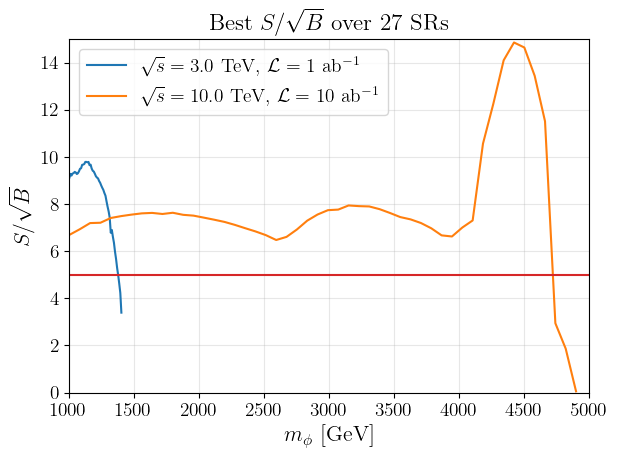

In [6]:
f = figure()
plot(rts3_runs.mphis, best_signif_mphi(bc_rts3, rts3_runs, 1e6),
    label=L"$\sqrt{s} = %$(rts3_runs.rts*1e-3)$ TeV, $\mathcal{L} = 1$ ab$^{-1}$")
plot(rts10_runs.mphis, best_signif_mphi(bc_rts10, rts10_runs, 10e6),
    label=L"$\sqrt{s} = %$(rts10_runs.rts*1e-3)$ TeV, $\mathcal{L} = 10$ ab$^{-1}$")
axhline(5, c="tab:red")
xlim(1000,5000)
ylim(0,15)
title(L"Best $S/\sqrt{B}$ over 27 SRs")
xlabel(L"$m_\phi$ [GeV]")
ylabel(L"S/\sqrt{B}")
grid(alpha=0.3)
legend()
plotclose()
# f.savefig(FIGDIR*"best_signif.pdf")
f

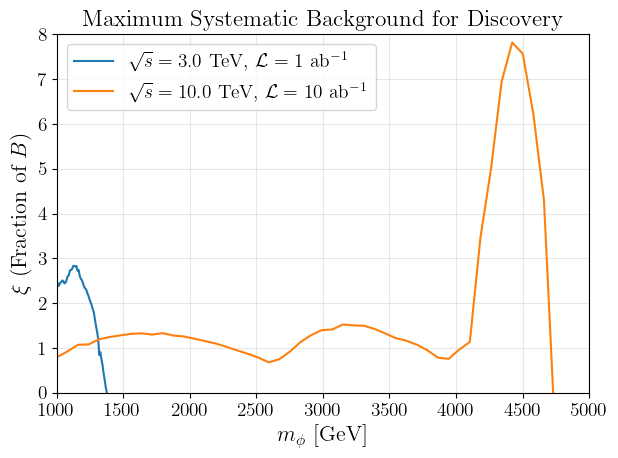

In [6]:
f = figure()
plot(rts3_runs.mphis, max_sys.(best_signif_mphi(bc_rts3, rts3_runs, 1e6)),
    label=L"$\sqrt{s} = %$(rts3_runs.rts*1e-3)$ TeV, $\mathcal{L} = 1$ ab$^{-1}$")
plot(rts10_runs.mphis, max_sys.(best_signif_mphi(bc_rts10, rts10_runs, 10e6)),
    label=L"$\sqrt{s} = %$(rts10_runs.rts*1e-3)$ TeV, $\mathcal{L} = 10$ ab$^{-1}$")
# axhline(5, c="tab:red")
xlim(1000,5000)
ylim(0,8)
title("Maximum Systematic Background for Discovery")
xlabel(L"$m_\phi$ [GeV]")
ylabel(L"$\xi$ (Fraction of $B$)")
grid(alpha=0.3)
legend()
plotclose()
# f.savefig(FIGDIR*"max_systematics.pdf")
f

# Discovery Regions

In [8]:
function sig_ranges(runs, lumi, SR_table, ε)

    mll_mins = SR_table[!,"mll_min [GeV]"]
    ptll_mins = SR_table[!,"ptll_min [GeV]"]
    mt2_mins = SR_table[!,"mt2_min [GeV]"]

    res = zeros(Float64, (length(runs.mphis), nrow(SR_table)))
    resb = zeros(Float64, length(runs.mphis))
    sigs = zeros(Float64, (length(runs.mphis), nrow(SR_table)))

    for i in 1:length(runs.mphis)
        thisrun = get_run_with_summary(runs, i)
        for j in 1:nrow(SR_table)
            sigs[i,j] = significances(thisrun, lumi, mll_mins[j], ptll_mins[j], 
                mt2_mins[j])[1]
            if sigs[i,j] >= 5
                res[i,j] = j+ε
            else
                res[i,j] = NaN
            end
        end
        jmax = argmax(sigs[i,:])
        resb[i] = jmax + ε
    end

    return res,resb
end

function best_SR(runs, lumi, SR_table)
    mll_mins = SR_table[!,"mll_min [GeV]"]
    ptll_mins = SR_table[!,"ptll_min [GeV]"]
    mt2_mins = SR_table[!,"mt2_min [GeV]"]

    resb = zeros(Int64, length(runs.mphis))
    sigs = zeros(Float64, (length(runs.mphis), nrow(SR_table)))

    for i in 1:length(runs.mphis)
        thisrun = get_run_with_summary(runs, i)
        for j in 1:nrow(SR_table)
            sigs[i,j] = significances(thisrun, lumi, mll_mins[j], ptll_mins[j], 
                mt2_mins[j])[1]
        end
        jmax = argmax(sigs[i,:])
        resb[i] = jmax
    end

    return resb
end

function plot_sig_ranges(runs1, runs2, lumi1, lumi2; ε=0.1, SRtab1=SR_table_3,
    SRtab2=SR_table_10)
    s1, b1 = sig_ranges(runs1, lumi1, SRtab1, ε)
    s2, b2 = sig_ranges(runs2, lumi2, SRtab2, -ε)

    left_ticks = ["$(round.(1e-3 .* Vector(SRtab1[i,1:3]), sigdigits=2))" for i in 1:nrow(SRtab1)]
    right_ticks = ["$(round.(1e-3 .* Vector(SRtab2[i,1:3]), sigdigits=2))" for i in 1:nrow(SRtab2)]
    push!(left_ticks, L"$m_{ll}$, $p_{T,ll}$, $M_{T2}$")
    push!(right_ticks, L"$m_{ll}$, $p_{T,ll}$, $M_{T2}$")

    f, ax1 = subplots(figsize=(golden_rat*5,5))
    ax2 = ax1.twinx()

    ax1.set_xlabel(L"$m_\phi$ [TeV]")
    ax1.set_ylabel(L"$\sqrt{s} = 3$ TeV Signal Regions")
    ax2.set_ylabel(L"$\sqrt{s} = 10$ TeV Signal Regions", rotation=270,
                    labelpad=16.0)

    for i in 1:nrow(SRtab1)
        ax1.plot(runs1.mphis .* 1e-3, s1[:,i], c="tab:blue")
        ax2.plot(runs2.mphis .* 1e-3, s2[:,i], c="tab:orange")
    end

    ax1.scatter(1e-3 .* runs1.mphis, b1, s=3., c="tab:blue", marker=3, linewidths=.5)
    ax2.scatter(1e-3 .* runs2.mphis, b2, s=3., c="tab:orange", marker=2, linewidths=.5)

    ax1.plot(0,Inf,lw=1.,c="tab:blue",label=L"$\sqrt{s}=3$ TeV")
    ax1.plot(0,Inf,lw=1.,c="tab:orange",label=L"$\sqrt{s}=10$ TeV")

    ax1.set_xlim(1, 5)
    ax1.set_ylim(0, 28)
    ax2.set_ylim(0, 28)
    ax1.set_yticks(1:28, left_ticks,
            fontsize=10)
    ax2.set_yticks(1:28, right_ticks,
            fontsize=10)
    ax1.grid(alpha=0.3)
    # ylabel("Signal Region")

    # ax1.legend(loc="upper left", fontsize=10)
    ax1.legend(loc="lower right", fontsize=10)

    # ax1.set_title("Regions of Discovery")

    plotclose()
    return f
end

function plot_sig_ranges(runs, lumi, SRtab; color="tab:blue")
    s1, b1 = sig_ranges(runs, lumi, SRtab, 0.0)

    left_ticks = ["$(round.(1e-3 .* Vector(SRtab[i,1:3]), sigdigits=2))" for i in 1:nrow(SRtab)]
    push!(left_ticks, L"$m_{\ell \ell}$, $p_{T,\ell \ell}$, $M_{T2}$")

    f, ax1 = subplots(figsize=(golden_rat*5,5))

    ax1.set_xlabel(L"$m_\phi$ [TeV]")
    ax1.set_ylabel(L"$\sqrt{s} = %$(runs.rts*1e-3)$ TeV Signal Regions")

    for i in 1:nrow(SRtab)
        ax1.plot(runs.mphis .* 1e-3, s1[:,i], c=color)
    end

    ax1.scatter(1e-3 .* runs.mphis, b1, s=5., c=color)

    # ax1.plot(0,Inf,lw=1.,c="tab:blue",label=L"$\sqrt{s}=3$ TeV")

    ax1.set_xlim(1, runs.rts*1e-3/2)
    ax1.set_ylim(0, 28)
    ax1.set_yticks(1:28, left_ticks,
            fontsize=10)
    ax1.grid(alpha=0.3)
    # ylabel("Signal Region")

    # ax1.legend(loc="upper left", fontsize=10)
    # ax1.legend(fontsize=10)

    plotclose()
    return f
end
;

In [ ]:
GC.gc()

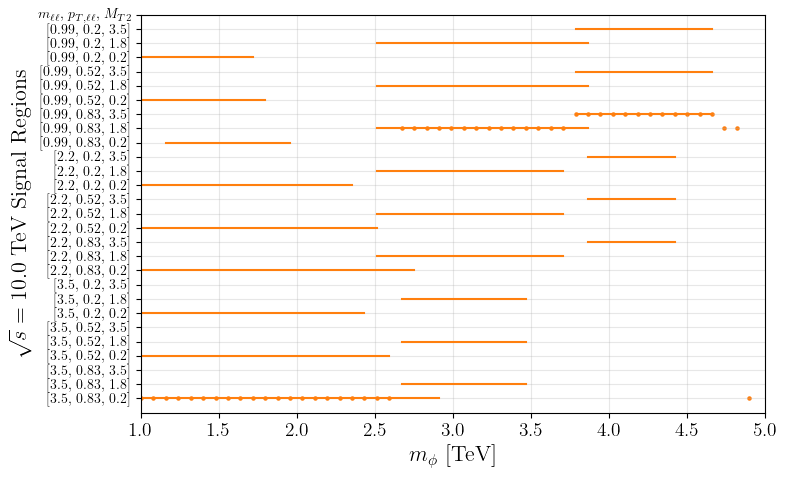

In [11]:
sr_lines_fig = plot_sig_ranges(rts10_runs, 10e6, SR_table_10; color="tab:orange")
sr_lines_fig.savefig(FIGDIR*"SR_lines_rts=10.pdf", bbox_inches="tight")
sr_lines_fig

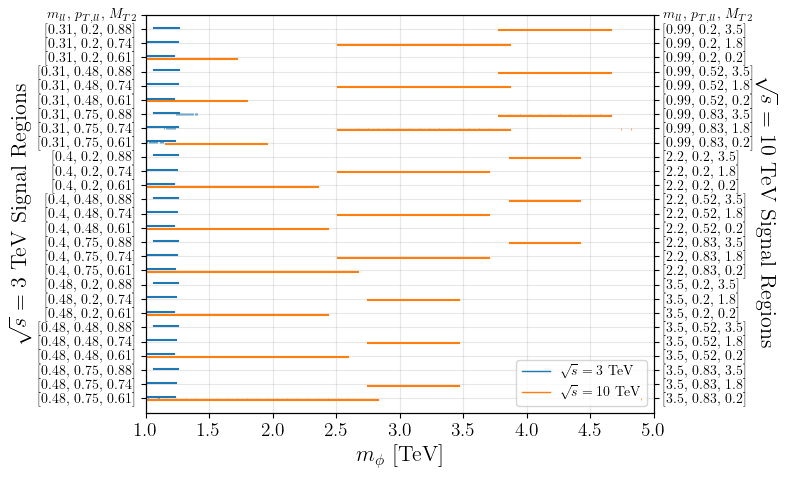

In [15]:
GC.gc()
fig2 = plot_sig_ranges(rts3_runs, rts10_runs, 1e6, 10e6)
fig2.savefig(FIGDIR*"SR_lines.pdf", bbox_inches="tight")
fig2

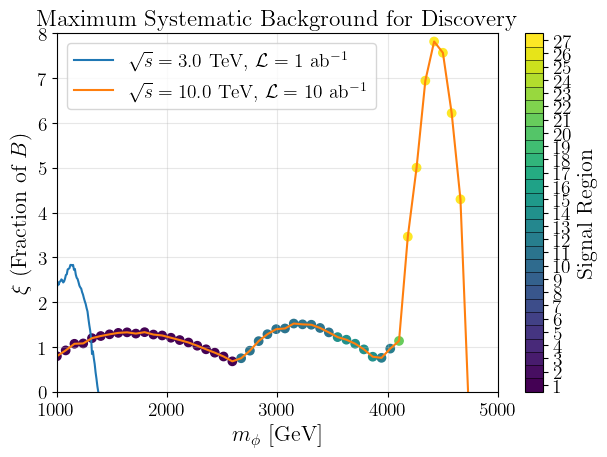

In [18]:
f = figure()
plot(rts3_runs.mphis, max_sys.(best_signif_mphi(bc_rts3, rts3_runs, 1e6)),
    label=L"$\sqrt{s} = %$(rts3_runs.rts*1e-3)$ TeV, $\mathcal{L} = 1$ ab$^{-1}$")
plot(rts10_runs.mphis, max_sys.(best_signif_mphi(bc_rts10, rts10_runs, 10e6)),
    label=L"$\sqrt{s} = %$(rts10_runs.rts*1e-3)$ TeV, $\mathcal{L} = 10$ ab$^{-1}$")
# axhline(5, c="tab:red")
sc = scatter(rts10_runs.mphis, max_sys.(best_signif_mphi(bc_rts10, rts10_runs, 10e6)), 
        c=best_SR(rts10_runs, 10e6, SR_table_10))
xlim(1000,5000)
ylim(0,8)
title("Maximum Systematic Background for Discovery")
xlabel(L"$m_\phi$ [GeV]")
ylabel(L"$\xi$ (Fraction of $B$)")
grid(alpha=0.3)
legend()
colorbar(sc, ticks=1:27, drawedges=true, boundaries=0.5:1:27.5, values=1:27,
    label="Signal Region")
plotclose()
f.savefig(FIGDIR*"max_systematics_SR.pdf")
f

# Max total sys bkg over 27 SRs

In [19]:
function N_signal(run, lumi, mins)
    mll_min = mins[1]
    ptll_min = mins[2]
    mt2_min = mins[3]

    mumu_frac = fcut(run.mumu_summary, mll_min, ptll_min, mt2_min)[1]
    vv_frac = fcut(run.vv_summary, mll_min, ptll_min, mt2_min)[1]

    N_mumu = run.mumu_xsec * lumi * mumu_frac
    N_vv = run.vv_xsec * lumi * vv_frac

    N_S = N_mumu + N_vv
    if N_S <= 20
        N_S = 0.0
    end

    return N_S
end

function N_bkg(run, lumi, mins)
    mll_min = mins[1]
    ptll_min = mins[2]
    mt2_min = mins[3]

    bkg_frac = fcut(run.bkg_summary, mll_min, ptll_min, mt2_min)[1]
    N_bkg = run.bkg_xsec * lumi * bkg_frac
    return N_bkg
end

function systematics(rts_runs, lumi, SR_table)
    N_mphi = length(rts_runs.mphis)
    N_SR = nrow(SR_table)

    mins = [Vector(SR_table[i,1:3]) for i in 1:N_SR]
    σ2s = zeros(Float64, (N_mphi,N_SR))

    for i in 1:N_mphi
        run = get_run_with_summary(rts_runs, i)
        N_Ss = N_signal.((run,), lumi, mins)
        N_Bs = N_bkg.((run,), lumi, mins)
        N_Bs = N_Bs .+ ((N_Bs .<= 2.0)*2.0)
        σ2s[i,:] = @. (N_Ss^2/N_Bs)/25 - 1.0
    end

    @. σ2s = σ2s + ((σ2s < 0) * NaN)

    return sqrt.(σ2s)
end

function sys_plot(rts_runs, lumi, SR_table)
    systems = systematics(rts_runs, lumi, SR_table)

    for i in eachindex(systems)
        if isnan(systems[i])
            systems[i] = 0.0
        end
    end

    sys_vv = [systems[:,i] for i in 1:27]
    sys_uni = unique(sys_vv)
    idxs = [findall(x -> x == v, sys_vv) for v in sys_uni]

    partition = Int(ceil(length(sys_uni)/3))
    println(partition)
    
    # SRs = [Vector(k)[systems_idxs[k]] for k in [1:9, 10:18, 19:27]]

    f, axs = subplots(3, 1, figsize=(5, 10))
    # f, axs = subplots(1, 3, figsize=(14, 5))

    i = 1
    j = 1
    for (k,v) in enumerate(sys_uni)
        if !(v == zero(v))
            axs[i-1].plot(1e-3*rts_runs.mphis, 100 .* v, label="SR $(idxs[k])")
        end

        j+=1

        if j > partition
            i+=1
            j=1
        end
    end

    for ax in axs
        ax.set_xlim(rts_runs.mphis[1]*1e-3, rts_runs.mphis[end]*1e-3)
        ax.set_ylim(0,100*6.25)
        ax.set_xlabel(L"$m_\phi$ [TeV]")
        ax.set_ylabel("Sys. / Stat. [\\%]")
        ax.grid(alpha=0.3)
        ax.legend(fontsize=12, ncol=1, loc="upper left")

        x_extent = 1e-3*(rts_runs.mphis[end] - rts_runs.mphis[1])

        ax.set_aspect(x_extent / (100*6.25*golden_rat))
    end

    f.suptitle(L"$\sqrt{s} = %$(rts_runs.rts*1e-3)$ TeV, $\mathcal{L} = %$(lumi*1e-6)$ ab$^{-1}$")

    # tight_layout(rect=(0, 0, 1, 1.05))

    plotclose()
    return f
end
;

In [9]:
systems10 = systematics(rts10_runs, 10e6, SR_table_10)
for i in eachindex(systems10)
    if isnan(systems10[i])
        systems10[i] = 0.0
    end
end
systems10_vv = [systems10[:,i] for i in 1:27]
test = [findall(x -> x == v, systems10_vv) for v in unique(systems10_vv)]

15-element Vector{Vector{Int64}}:
 [1]
 [2, 5, 8]
 [3, 6, 9]
 [4]
 [7]
 [10]
 [11, 14, 17]
 [12, 15, 18]
 [13]
 [16]
 [19]
 [20, 23, 26]
 [21, 24, 27]
 [22]
 [25]

5


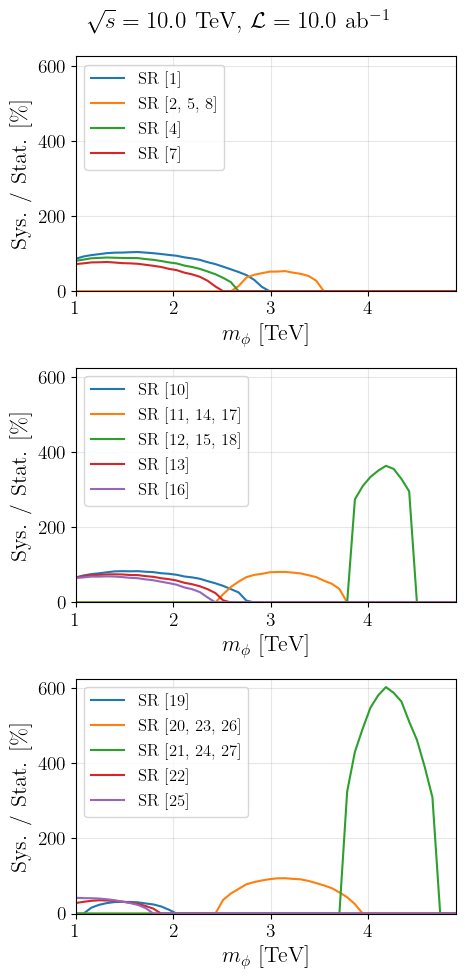

In [20]:
fsys = sys_plot(rts10_runs, 10e6, SR_table_10)
# fsys.savefig(FIGDIR*"tol_sys_rts=10.pdf", bbox_inches="tight")
fsys

# $S$ and $\sqrt{B}$ for given SR

In [48]:
function plot_S_and_B(rts_runs, lumi, mins, idx)#, ymax)
    N_mphi = length(rts_runs.mphis)

    N_Ss = zeros(Float64, N_mphi)
    N_B = N_bkg(get_run_with_summary(rts_runs, 1), lumi, mins)

    for i in 1:N_mphi
        run = get_run_with_summary(rts_runs, i)
        N_Ss[i] = N_signal(run, lumi, mins)
    end

    f = figure()
    plot(rts_runs.mphis .* 1e-3, log10.(N_Ss), label=L"S")
    axhline(log10.(5*sqrt(N_B)), label=L"5\sqrt{B}", c="tab:orange")
    xlim(rts_runs.mphis[1]*1e-3, 1e-3*rts_runs.rts/2)
    ylim(1, 4)
    xlabel(L"$m_\phi$ [TeV]")
    ylabel("Number of Events")
    grid(alpha=0.3)
    legend()

    x_extent = 1e-3*(rts_runs.rts/2 - rts_runs.mphis[1])
    y_extent = 4-1

    yticks = 1:4
    yticklabels = [L"10^{%$(round(Int, x))}" for x in yticks]

    ax = gca()
    ax.set_aspect(x_extent/(y_extent*golden_rat), adjustable="box")
    ax.set_yticks(yticks, yticklabels)

    ax.set_title(L"SR %$(idx): [$m_{\ell \ell}$, $p_{T,\ell \ell}$, $M_{T2}$] = %$(round.(mins .* 1e-3,sigdigits=3)) TeV")
    # ax.set_title("x")

    plotclose()
    return f
end
;

In [11]:
SR_mins_3 = [Vector(SR_table_3[i,1:3]) for i in 1:nrow(SR_table_3)];
SR_mins_10 = [Vector(SR_table_10[i,1:3]) for i in 1:nrow(SR_table_10)];

In [9]:
N_S_test = zeros(Float64, length(rts3_runs.mphis))
for i in 1:length(rts3_runs.mphis)
    run = get_run_with_summary(rts3_runs, i)
    N_S_test[i] = N_signal(run, 1e6, SR_mins_3[9])
end
;

In [13]:
rts3_runs.mphis[40]

1318.3673469387754

In [12]:
N_S_test[30:41]

12-element Vector{Float64}:
 46.92655730795291
 48.09336976267233
 48.834714565964994
 49.50599754493358
 50.111045862265904
 50.612865112146295
 49.93601779027284
 49.84511566447959
 49.062847817946924
 47.93535907973977
 34.26463859082634
 45.54759652670158

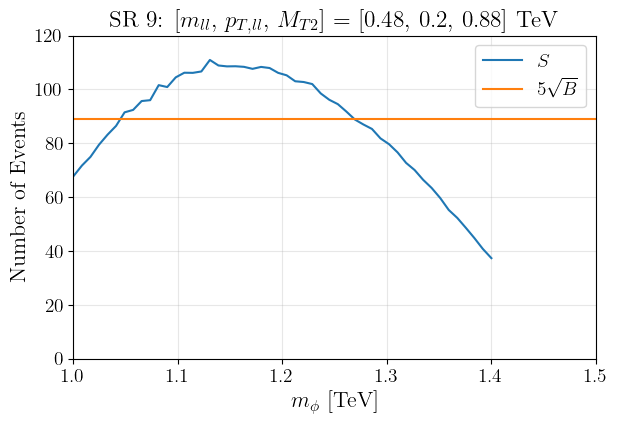

In [29]:
srN_rts3_fig = plot_S_and_B(rts3_runs, 1e6, SR_mins_3[9], 9, 120)
# title(L"[0, 0, 0] GeV cuts ($\sqrt{s}=3$ TeV, $\mathcal{L} = 1$ ab$^{-1}$)")
plotclose()
srN_rts3_fig.savefig(FIGDIR*"test_sb9_rts=3.pdf", bbox_inches="tight")
srN_rts3_fig

In [28]:
srN = 9
srN_rts3_fig = plot_S_and_B(rts3_runs, 1e6, SR_mins_3[srN])
title(L"SR %$(srN) ($\sqrt{s}=3$ TeV, $\mathcal{L} = 1$ ab$^{-1}$)")
plotclose()
# srN_rts3_fig.savefig(FIGDIR*"sr$(srN)_sb_rts=3.pdf", bbox_inches="tight")
srN_rts3_fig

MethodError: MethodError: no method matching plot_S_and_B(::NamedTuple{(:rts, :run_ids, :mphis, :mumu_xsecs, :vv_xsecs, :bkg_summary, :bkg_xsec, :bkg_dir, :mumu_dir, :vbf_dir), Tuple{Float64, Vector{Int64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Adjoint{Float64, Matrix{Float64}}, Float64, String, String, String}}, ::Float64, ::Vector{Int64})

Closest candidates are:
  plot_S_and_B(::Any, ::Any, ::Any, !Matched::Any, !Matched::Any)
   @ Main ~/Dropbox (University of Oregon)/MuC/Aria/one_flav/code/prompt/MG_analysis_phiscan.ipynb:1


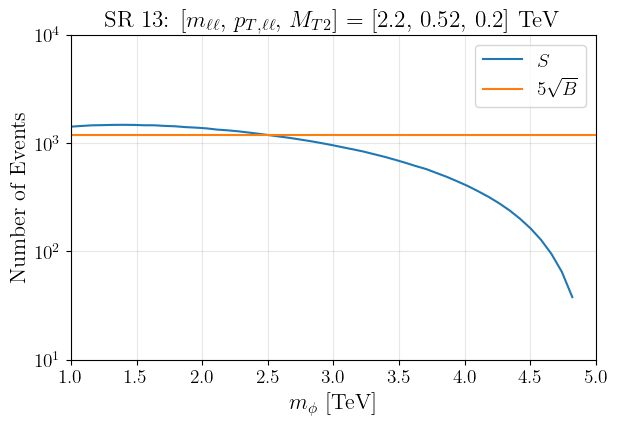

In [49]:
sr13_fig = plot_S_and_B(rts10_runs, 10e6, SR_mins_10[13], 13)#, 2000)
# title("SR 13 $(SR_mins_10[13]): Signal and Background")
sr13_fig.savefig(FIGDIR*"sr13_sb.pdf", bbox_inches="tight")
sr13_fig

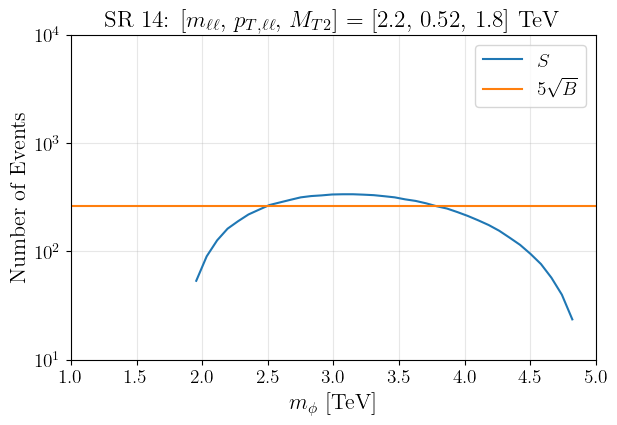

In [50]:
sr14_fig = plot_S_and_B(rts10_runs, 10e6, SR_mins_10[14], 14)#, 400)
sr14_fig.savefig(FIGDIR*"sr14_sb.pdf", bbox_inches="tight")
sr14_fig

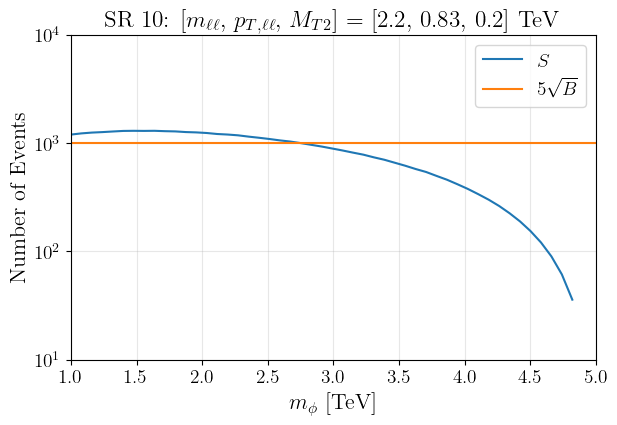

In [52]:
sr10_fig = plot_S_and_B(rts10_runs, 10e6, SR_mins_10[10], 10)#, 1400)
# title("SR 10 $(SR_mins_10[10]): Signal and Background")
sr10_fig.savefig(FIGDIR*"sr10_sb.pdf", bbox_inches="tight")
sr10_fig

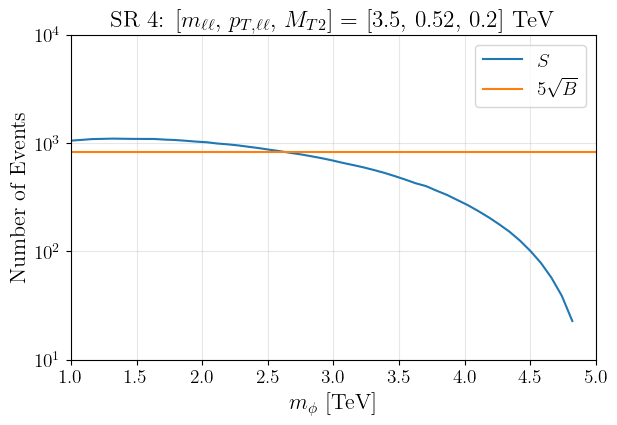

In [53]:
sr4_fig = plot_S_and_B(rts10_runs, 10e6, SR_mins_10[4], 4)#, 1200)
# title("SR 4 $(SR_mins_10[4]): Signal and Background")
sr4_fig.savefig(FIGDIR*"sr4_sb.pdf", bbox_inches="tight")
sr4_fig